# Lab 4 (part 1): PyTorch basics
In this lab we will use PyTorch to implement linear regression. We will implement Gradient Descent.

Let's first import what we need:

In [1]:
%matplotlib inline
import torch
import numpy as np
from matplotlib import pyplot as plt

## 1. Training set
The goal of linear regression is to fit a line to a set of points. We will generate a traing set of n = 100 random samples.

In [2]:
# Number of samples
n=100

PyTorch and other deep learning frameworks use Tensors instead of arrays. Tensors are similar to numpy’s ndarrays (i.e., multi-dimensional arrays), with the addition being that Tensors can also be used on a GPU to accelerate computing. See intro [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

Let's first define some random x-values in the range -1 to 1.

In [3]:
x = torch.ones(n,2) # Tensor
x[:,0].uniform_(-1.,1)
print(x[:5])

tensor([[ 0.7002,  1.0000],
        [-0.1351,  1.0000],
        [ 0.2309,  1.0000],
        [ 0.2483,  1.0000],
        [ 0.4053,  1.0000]])


### Questions 1:
- What do you think  the column of 1's is used for?
- What does the function `.uniform_()` do?
- PyTorch functions with suffix `_` have a special meaning. Can you figure out what they mean?

Now, define the ground truth weights of the linear model:

In [4]:
w = np.array([3.,2]).astype(np.float32) # Numpy array
w = torch.from_numpy(w) # Tensor
w

tensor([3., 2.])

Generate y-values by applying the model and adding random noise.

In [5]:
y = x@w + torch.rand(n)

In the above, the @ stands for the dot product operation.

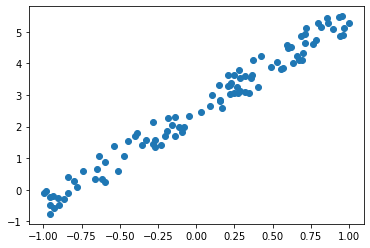

In [6]:
plt.scatter(x[:,0], y);

## 2. Loss function

We want to find weights `w` such that we minimize the *error* between the points and the line `x@w`. Note that here `w` is unknown. For a regression problem the most common *error function* or *loss function* is the mean squared error or **quadratic error**:

In [7]:
def mse(y_hat, y):
  return ((y_hat-y)**2).mean()

Suppose we hypothesize that `w = (-1.0,1.0)`. Then we can compute `y_hat` which is our *prediction* and then compute our error.

In [8]:
w = np.array([-1.,1]).astype(np.float32)
w = torch.as_tensor(w)
y_hat = x@w
loss = mse(y, y_hat)
print(loss)

tensor(8.4526)


Notice what is printed here: `loss` is a tensor with a scalar value.  

Plot the corresponding line:

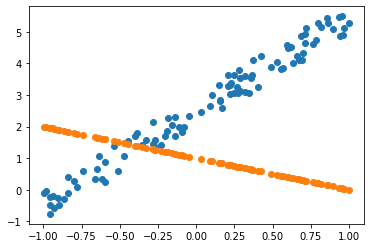

In [9]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);

## Optimization with Autograd

So far we have specified the *model* (linear regression) and the *loss function*. Now we need to handle *optimization*; that is, how do we find the best values for `w`? How do we find the best *fitting* linear regression. We would like to find the values of `w` that minimizes the `mse` loss.

**Gradient descent** is an algorithm that minimizes functions. Given a loss function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the loss. This iterative minimization is achieved by taking steps in the negative direction of the loss gradient w.r.t the parameters.

Central to all models implemented in PyTorch is the **Autograd package**. 
The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backpropagation is defined by how your code is run, and that every single iteration can be different.

`torch.Tensor` is a central class. If you set its attribute `.requires_grad = True`, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

First set `w.requires_grad = True` to track computation with it:

In [10]:
w.requires_grad = True
w

tensor([-1.,  1.], requires_grad=True)

There’s one more class which is very important for autograd implementation - a Function.

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a `.grad_fn` attribute that references a Function that has created the Tensor.

When you compute the loss again, it is created as a result of an operation, so now it has a `grad_fn`:

In [11]:
y_hat = x@w
loss = mse(y, y_hat)
print(loss)

tensor(8.4526, grad_fn=<MeanBackward0>)


Let’s backprop now to compute the gradient of `w` with respect to the loss:

In [12]:
loss.backward()

### Question 2:
- Can you figure out how to extract the gradient of the loss w.r.t. to `w`? (Hint: It has just been calculated by calling loss.backward(), but where is it stored?)

**Note:** You can stop autograd from tracking history on Tensors by wrapping the code block in

```
with torch.no_grad()
```

We usually do this when updating the parameters (weights) during gradient descent, because we do not want these operations to be recorded for our next calculation of the gradient.

Putting all the pieces together, here is the update function for gradient descent:


In [13]:
def update():

    # predict
    y_hat = x@w

    # calculate loss
    loss = mse(y, y_hat)
    
    if epoch % 10 == 0: print(loss)
    
    # calculate gradient of loss
    loss.backward()

    # update parameters (temporarily stop autograd from tracking history)
    with torch.no_grad():
        w.sub_(lr * w.grad) # in-place subtraction
        w.grad.zero_()  # zero the gradients after the update operation

### Question 3:
- What does `w.grad.zero_()` do, and why is it necessary to call this function?

In [14]:
lr = 1e-1
for epoch in range(100):
  update()

tensor(8.4526, grad_fn=<MeanBackward0>)
tensor(1.1382, grad_fn=<MeanBackward0>)
tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(0.1429, grad_fn=<MeanBackward0>)
tensor(0.0988, grad_fn=<MeanBackward0>)
tensor(0.0884, grad_fn=<MeanBackward0>)
tensor(0.0859, grad_fn=<MeanBackward0>)
tensor(0.0854, grad_fn=<MeanBackward0>)
tensor(0.0852, grad_fn=<MeanBackward0>)
tensor(0.0852, grad_fn=<MeanBackward0>)


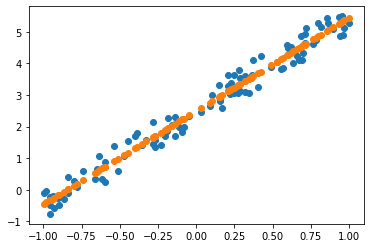

In [15]:
w.requires_grad = False # Disable gradients, otherwise pyplot refuses to plot x@w
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@w);

## Animate it!
This is just for fun :-)

In [16]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [ ]:
w = np.array([-1.,1]).astype(np.float32)
w = torch.as_tensor(w)

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@w)
plt.close()

def animate(i):
    w.requires_grad = True
    update()
    w.requires_grad = False
    line.set_ydata(x@w)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

In practice, we usually don't calculate the gradients on the whole training set at once, but we use *mini-batches*. Then gradient descent becomes Stochastic Gradient Descent (SGD).

## Vocab

- Learning rate
- Epoch
- Minibatch
- SGD
- Model / Architecture
- Parameters
- Loss function